### The Data

In [1]:
import pandas as pd

In [2]:
# https://www.kaggle.com/joshmcadams/oranges-vs-grapefruit
df = pd.read_csv('data/citrus.csv')

In [3]:
df.sample(5)

,diameter,weight,hexcode,fruit
8723,11.05,190.96,#9D4817,grapefruit
237,11.68,200.93,#914302,grapefruit
2356,11.69,201.13,#933F08,grapefruit
5734,7.45,137.41,#9D5418,orange
4949,7.43,137.10,#9E4E03,orange


In [4]:
df.shape

(10000, 4)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
diameter,10000.0,9.975685,1.947844,2.96,8.46,9.980,11.4800,16.45
weight,10000.0,175.050792,29.212119,86.76,152.22,174.985,197.7225,261.51


### Select + Split

In [6]:
target = 'fruit'
y = df[target]
X = df.drop(target, axis=1)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
X_train.head(5)

,diameter,weight,hexcode
4901,11.85,203.54,#9D4B18
4375,7.87,143.57,#9F5502
6698,8.19,142.93,#953F10
9805,7.12,133.20,#AF6402
1101,7.61,139.68,#9B500D


### Dealing with hexcodes

In [10]:
from matplotlib import pyplot as plt

In [11]:
def plot_color(color):
    plt.scatter([1], [1], c=color, s=10000)
    plt.xticks([])
    plt.yticks([])
    plt.show()

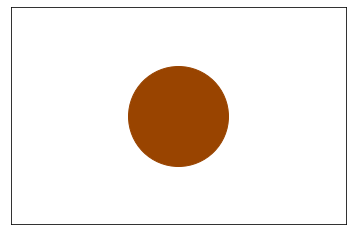

In [17]:
plot_color('#994400') R G B

In [18]:
def hex2rgb(hex):
    hex = hex.replace('#', '')
    return int(hex[0:2],16), int(hex[2:4],16), int(hex[4:6],16)

In [19]:
hex2rgb('#AF6402')

(175, 100, 2)

In [20]:
df['hexcode'].apply(hex2rgb)

0        (147, 74, 7)
1       (152, 61, 25)
2       (159, 87, 18)
3       (151, 62, 14)
4        (152, 82, 9)
            ...      
9995     (145, 70, 6)
9996     (127, 98, 2)
9997    (147, 69, 17)
9998    (159, 100, 2)
9999    (149, 71, 29)
Name: hexcode, Length: 10000, dtype: object

In [21]:
X_train['hexcode'].apply(hex2rgb).apply(pd.Series)

,0,1,2
4901,157,75,24
4375,159,85,2
6698,149,63,16
9805,175,100,2
1101,155,80,13
...,...,...,...
5734,157,84,24
5191,133,83,12
5390,150,72,2
860,143,80,31


In [22]:
class HexTransformer:
    
    @staticmethod
    def hex2rgb(hex):
        hex = hex.replace('#', '')
        return int(hex[0:2],16), int(hex[2:4],16), int(hex[4:6],16)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(self.hex2rgb).apply(pd.Series)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [23]:
ht = HexTransformer()
ht.fit_transform(X_train['hexcode'])

,0,1,2
4901,157,75,24
4375,159,85,2
6698,149,63,16
9805,175,100,2
1101,155,80,13
...,...,...,...
5734,157,84,24
5191,133,83,12
5390,150,72,2
860,143,80,31


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [25]:
X_train.head(5)

,diameter,weight,hexcode
4901,11.85,203.54,#9D4B18
4375,7.87,143.57,#9F5502
6698,8.19,142.93,#953F10
9805,7.12,133.20,#AF6402
1101,7.61,139.68,#9B500D


In [26]:
mapper = DataFrameMapper([
    ('hexcode', HexTransformer(), {'input_df': True}),
    (['diameter'], StandardScaler()), 
    (['weight'], StandardScaler()),
], df_out=True)

In [27]:
Z_train = mapper.fit_transform(X_train)

In [28]:
Z_train.head()

,hexcode_0,hexcode_1,hexcode_2,diameter,weight
4901,157,75,24,0.950395,0.962671
4375,159,85,2,-1.086118,-1.082380
6698,149,63,16,-0.922379,-1.104205
9805,175,100,2,-1.469884,-1.436010
1101,155,80,13,-1.219157,-1.215034


In [29]:
Z_test = mapper.transform(X_test)

In [30]:
Z_test.head()

,hexcode_0,hexcode_1,hexcode_2,diameter,weight
6252,159,84,15,-0.600016,-0.596779
4684,160,83,2,-0.538614,-0.523461
1731,169,90,4,0.668967,0.589262
4742,154,83,17,-0.559081,-0.550060
4521,179,84,4,-0.722821,-0.730115


### The Model

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
model = KNeighborsClassifier()

In [33]:
model.fit(Z_train, y_train)

KNeighborsClassifier()

In [34]:
model.score(Z_train, y_train)

0.9185333333333333

In [35]:
model.score(Z_test, y_test)

0.8704

In [36]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(Z_train, y_train)

dummy.score(Z_train, y_train), (dummy.score(Z_test, y_test))

/Users/max/opt/miniconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


(0.5041333333333333, 0.504)

### Pipeline

In [37]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(mapper, model)

In [38]:
X_train

,diameter,weight,hexcode
4901,11.85,203.54,#9D4B18
4375,7.87,143.57,#9F5502
6698,8.19,142.93,#953F10
9805,7.12,133.20,#AF6402
1101,7.61,139.68,#9B500D
...,...,...,...
5734,7.45,137.41,#9D5418
5191,11.00,190.28,#85530C
5390,8.66,155.25,#964802
860,12.60,214.76,#8F501F


In [39]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8704

In [40]:
X_train.sample().to_dict(orient='list')

{'diameter': [11.19], 'weight': [193.17], 'hexcode': ['#965107']}

In [54]:
X_new = pd.DataFrame({
    'diameter': [8.0], 
    'weight': [100], 
    'hexcode': ['#f4a261']
})

In [55]:
pipe.predict(X_new)

array(['orange'], dtype=object)

#### Pickle 

In [56]:
import pickle

In [57]:
with open('pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)

del pipe

In [58]:
with open('pipe.pkl', 'rb') as f:
    pipe = pickle.load(f)

In [60]:
pipe.predict(X_new)[0]

'orange'